In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Module 1

## Lecture 1

### **1**

Let's consider a waveform, which represents different sounds:

![](./images/3-s2.0-B9780128130865000037-f05-09-9780128130865.jpg)

Can we decompose an arbitrary wave into Fourier series with high precision? - Yes, but with a very high value of N.

> <span style="color:red">**TODO**</span>: Why?

Because the Fourier series seeks to represent the input signal using a new **orthogonal basis**:

$$\left\{ 1, \cos \left( 2\pi n x \right), \sin \left( 2\pi n x \right) \right\} _{n = 1}^{\infty}$$

Since the signal is high-dimensional in the function space, the number **N** determines how many basis components we use in the approximation — similar to a **rank-N approximation in SVD**, where more components capture more structure in the original data.

Thus, using a large **N** allows capture more high-frequency components and finer details of the signal, resulting in a more precise approximation.

### **2**


But in practice having such a big N value is not reasonable because:

- We again get high resolution data.
- It is an "overfit".

Let's consider an alternative approach. One way to simplify a complex waveform is to split it into windows. "Window" waveforms are much less complex.

> <span style="color:red">**TODO**</span>: Why?


Because each window covers only a short segment of the full waveform, it likely contains fewer frequency components and less variation. Over a short duration, the signal tends to be more stable, making it simpler and easier to model with fewer Fourier terms. By analyzing smaller windows, we reduce the signal’s complexity in each part, avoiding the need for a high **N** over the entire waveform.

> <span style="color:red">**TODO**</span>: How does resampling work?

> <span style="color:red">**TODO**</span>: Why does resampling "not work" in the Spectral domain?

### **3**

> <span style="color:red">**TODO**</span>: How does resampling work?

There are two main types of resampling: **upsampling** and its opposite, **downsampling**.

**Upsampling** increases the sampling rate. In the basic approach, empty slots of the same size are inserted between existing samples, often initialized with zeros. These gaps are then filled using interpolation techniques to estimate the missing values. More advanced methods, such as Fourier-based imputing, can also be used to improve the accuracy of the reconstructed signal.

**Downsampling**, on the other hand, reduces the sampling rate. The most basic and least effective method is to simply drop samples at regular intervals to achieve the desired size. More sophisticated approaches apply averaging over a fixed-size window, such as a rolling average, to preserve more of the signal's structure and reduce aliasing.

### **4**

> <span style="color:red">**TODO**</span>: Why does resampling "not work" in the Spectral domain?

Because changes in one domain affect the other non-linearly, resampling directly in the frequency domain often does not produce the desired result. For example, downsampling by simply removing high-frequency components causes loss of phase information, which in turn leads to aliasing and distortion in the reconstructed signal.

## Lecture 2

> <font color='red'>**TODO**</font>: Implement Butterworth Filter from scratch.

In [35]:
from scipy.signal import bilinear

def butterworth_coeffs(cutoff_freq, fs, order=4):
    warped = 2 * fs * np.tan(np.pi * cutoff_freq / fs)
    poles = []
    for k in range(1, 2 * order, 2):
        angle = np.pi * k / (2 * order)
        pole = warped * np.exp(1j * (np.pi / 2 + angle))
        poles.append(pole)
    poles = np.array(poles)

    a_analog = np.poly(poles).real
    b_analog = np.array([warped ** order])

    b, a = bilinear(b_analog, a_analog, fs)
    return b, a


def apply_filter(b, a, x):
    y = np.zeros_like(x)
    order = len(a) - 1

    for n in range(len(x)):
        xn = x[n]
        yn = b[0] * xn
        for i in range(1, order + 1):
            if n - i >= 0:
                yn += b[i] * x[n - i] - a[i] * y[n - i]
            else:
                yn += b[i] * 0 - a[i] * 0 
        y[n] = yn
    return y

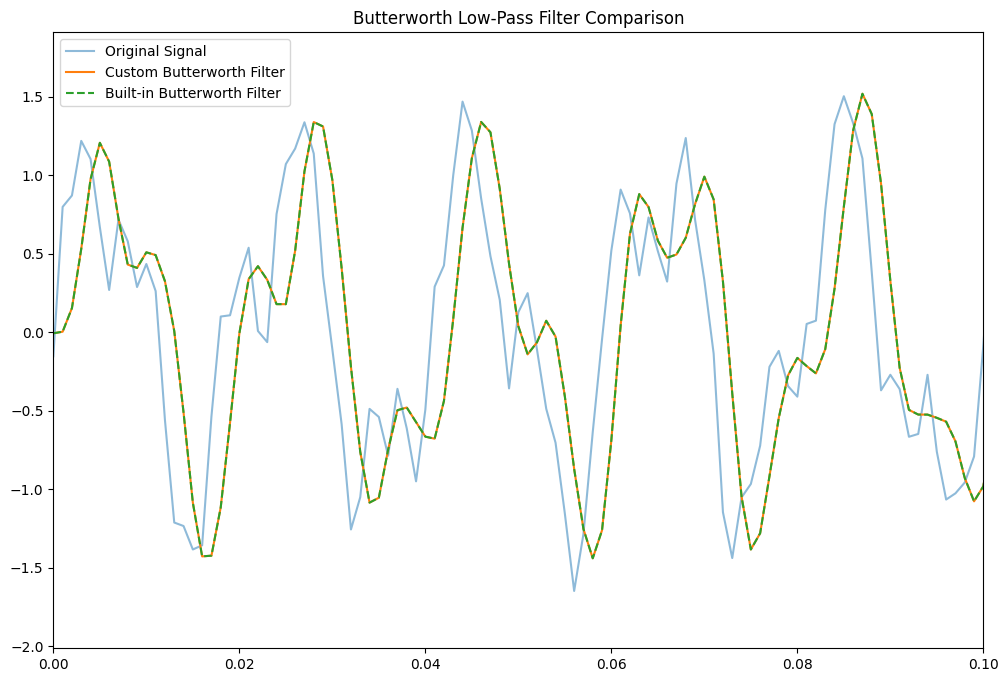

In [38]:
from scipy.signal import butter, lfilter

fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)

x = np.sin(2* np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t) + 0.2 * np.sin(2 * np.pi * 300 * t)
x += 0.1 * np.random.randn(len(t))

cutoff = 200
order = 4

b_custom, a_custom = butterworth_coeffs(cutoff, fs, order)

y_custom = apply_filter(b_custom, a_custom, x)

b_builtin, a_builtin = butter(order, cutoff, fs=fs, btype='low')
y_builtin = lfilter(b_builtin, a_builtin, x)

plt.figure(figsize=(12, 8))
plt.plot(t, x, label='Original Signal', alpha=0.5)
plt.plot(t, y_custom, label='Custom Butterworth Filter')
plt.plot(t, y_builtin, label='Built-in Butterworth Filter', linestyle='--')
plt.xlim(0, 0.1)
plt.legend()
plt.title("Butterworth Low-Pass Filter Comparison")
plt.show()